In [1]:
import ROOT
import sys,os,string,json,math
import makeCanvas

from Utilities import getListOfTypes,maxval,calculate,movetofront,getMapOfTypes,setXYLabels

app = "eventdump"
maxrate = 40.0

# def calculate(r=None):
#     if  "job_cpu_time" in r and "job_wall_time" in r and float(r["job_wall_time"]) > 0:
#         r["job_efficiency"] = float(r["job_cpu_time"])/float(r["job_wall_time"])
#     else:
#         r["job_efficiency"] = -.1
#     if float(r["event_count"]) > 0 :
#         r["time_per_event"] = float(r["duration"])/float(r["event_count"])
    

here = os.path.join(os.getenv("PWD"),"data")

print (here)

files = []
for (path, dirnames, filenames) in os.walk(here):
    for f in filenames:
        if "json" in f and "combined" not in f:
            files.append(os.path.join(path,f))
            
#print (files)

data = []
for f in files:
    #print (f)
    jsonfile = open(f,'r')
    thing = json.load(jsonfile)
    if thing["event_count"] == 0 :
        continue
    if thing["application_name"] != app:
        continue
    thing = calculate(thing)
    if thing == None: continue
    
    data.append(thing)
   # print (f,data)
    jsonfile.close()
    
o = open("combined.json",'w')
json.dump(data,o)
o.close()



Welcome to JupyROOT 6.24/02
/Users/schellma/Dropbox/LArWrapperExample/analysis/data
art_total_events  is None in  np04_raw_run005204_0001_dl3_reco1_38929418_0_20201107T054437Z.root
art_total_events  is None in  np04_raw_run005204_0001_dl1_reco1_38929503_0_20201107T054837Z.root
art_total_events  is None in  np04_raw_run005204_0001_dl2_reco1_38929494_0_20201107T233907Z.root
art_total_events  is None in  np04_raw_run005786_0001_dl1_reco1_38359567_0_20201110T025457Z.root
art_total_events  is None in  np04_raw_run005786_0001_dl2_reco1_38359412_0_20201110T025348Z.root
art_total_events  is None in  np04_raw_run005786_0001_dl7_reco1_38359452_0_20201110T025344Z.root
art_total_events  is None in  np04_raw_run005786_0001_dl9_reco1_38358972_0_20201110T024747Z.root
art_total_events  is None in  np04_raw_run005786_0001_dl8_reco1_38359006_0_20201110T024748Z.root
art_total_events  is None in  np04_raw_run005244_0001_dl6_reco1_38903477_0_20201121T055757Z.root
art_total_events  is None in  np04_raw_run0

In [2]:
i = open("combined.json",'r')
records = json.load(i)



In [3]:
listofsites = getListOfTypes(data,"job_site",[])

nsites=len(listofsites)
mapofsites = getMapOfTypes(listofsites)

listofrses = getListOfTypes(data,"rse",[])
nrses = len(listofrses)
mapofrses = getMapOfTypes(listofrses)

print (mapofsites)

print (mapofrses)

hists = {}

colors = {"Requested":ROOT.kViolet,"Opened":ROOT.kRed,"Closed":ROOT.kGreen,"Rate":ROOT.kBlack,"RateN":ROOT.kBlack}

for name in ["Requested","Opened","Closed","Rate","RateN"]:
    hists[name] = ROOT.TH2D(name,name,nsites,0,nsites,nrses,0.,nrses)
    setXYLabels(hists[name],mapofsites,mapofrses)
    hists[name].SetLineColor(colors[name])
    hists[name].SetFillColor(colors[name])
    hists[name].GetXaxis().SetTitle("Job_Site")
    hists[name].GetYaxis().SetTitle("RSE")
    

{'BR_CBPF': 1, 'CA_Victoria': 2, 'CERN': 3, 'CZ_FZU': 4, 'ES_CIEMAT': 5, 'ES_PIC': 6, 'NL_NIKHEF': 7, 'NL_SURFsara': 8, 'RU_JINR': 9, 'UK_Bristol': 10, 'UK_Brunel': 11, 'UK_Imperial': 12, 'UK_Lancaster': 13, 'UK_Manchester': 14, 'UK_Oxford': 15, 'UK_QMUL': 16, 'UK_RAL-PPD': 17, 'UK_RAL-Tier1': 18, 'UK_Sheffield': 19, 'US_BNL': 20, 'US_Colorado': 21, 'US_FermiGrid': 22, 'US_Michigan': 23, 'US_NotreDame': 24, 'US_PuertoRico': 25, 'US_SU-ITS': 26, 'US_Swan': 27, 'US_UCSD': 28, 'US_Wisconsin': 29}
{'FNAL_DCACHE': 1, 'LANCASTER': 2, 'MANCHESTER': 3}


In [4]:
for r in data: 
    if r == None: continue
    if "job_site" not in r:
        print ("no jobsite in ",r["name"])
        continue
    if r["job_site"] == None: r["job_site"] = "Unknown"
        
    isite = mapofsites[r["job_site"]] -.5
    irse = mapofrses[r["rse"]]-.5
    state = r["final_state"]
    
    hists[state].Fill(isite,irse)
    if state == "Closed" and "rate" in r: 
        hists["Rate"].Fill(isite,irse,r["rate"])
        hists["RateN"].Fill(isite,irse,1.0)
        #print (r["job_site"],r["rate"])
    
    

Info in <TCanvas::Print>: jpg file Rate.jpg has been created
Info in <TCanvas::Print>: jpg file AverageRate.jpg has been created


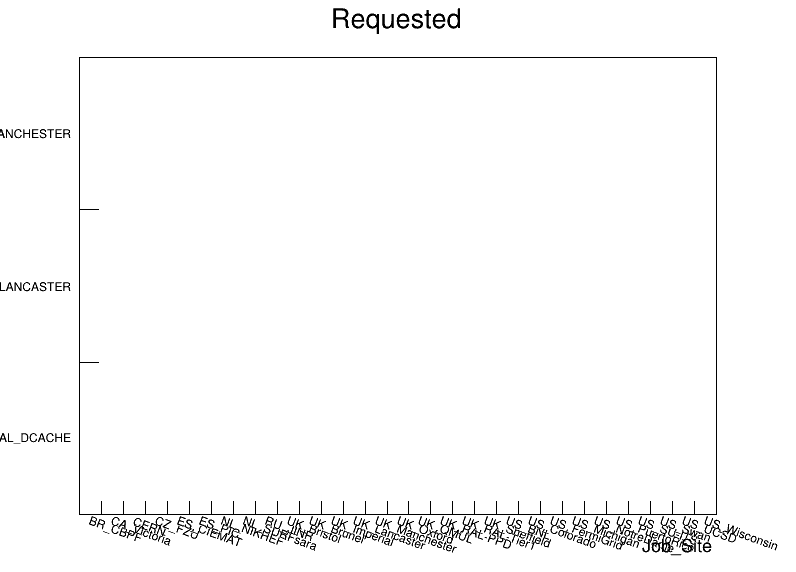

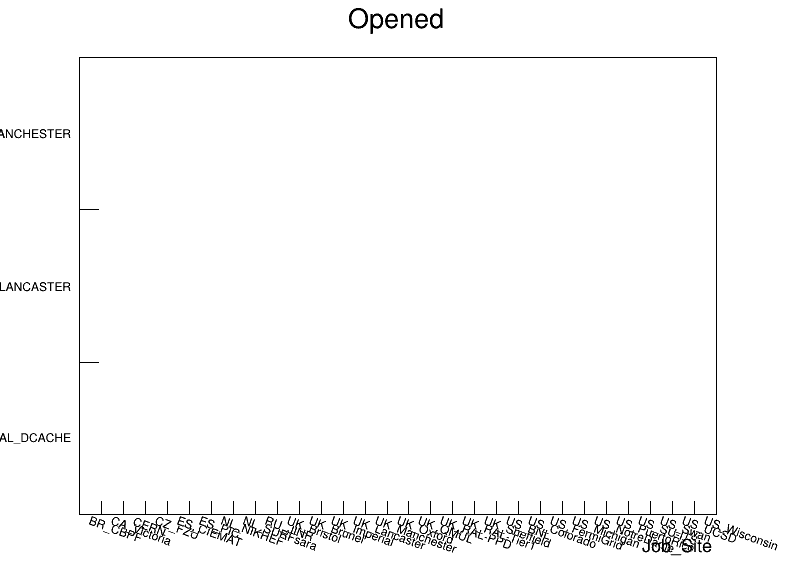

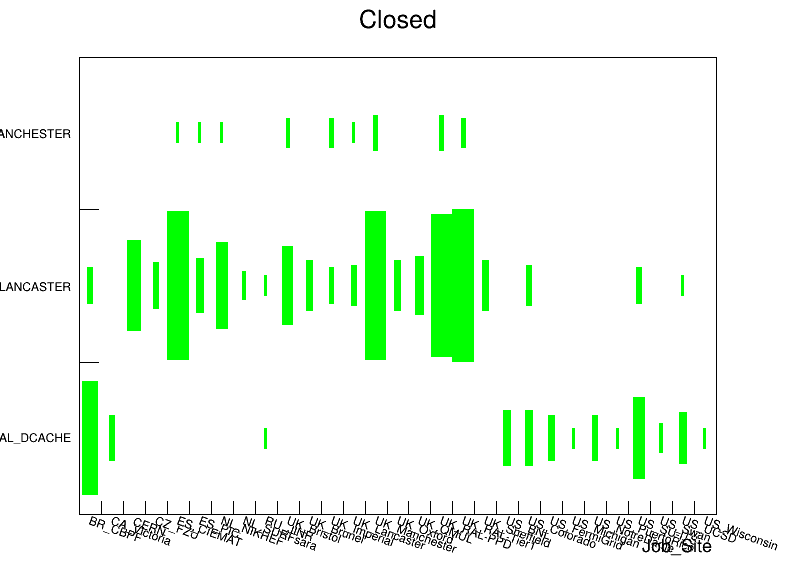

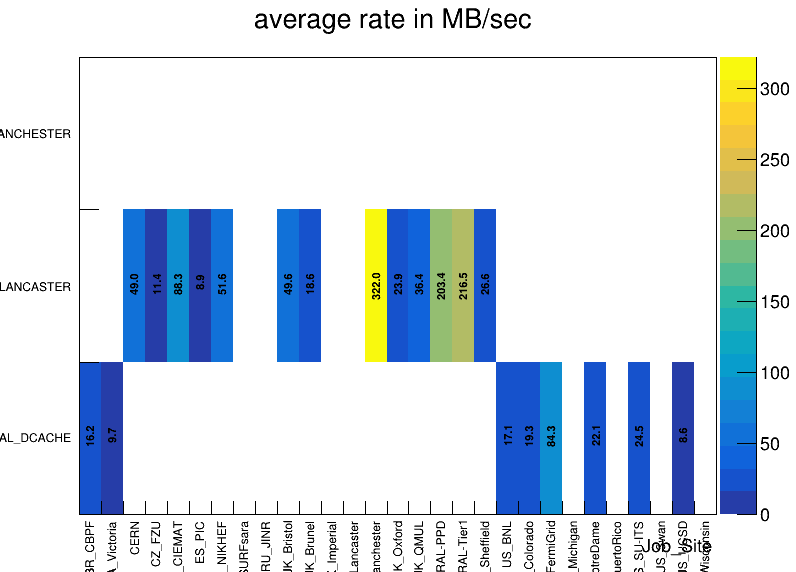

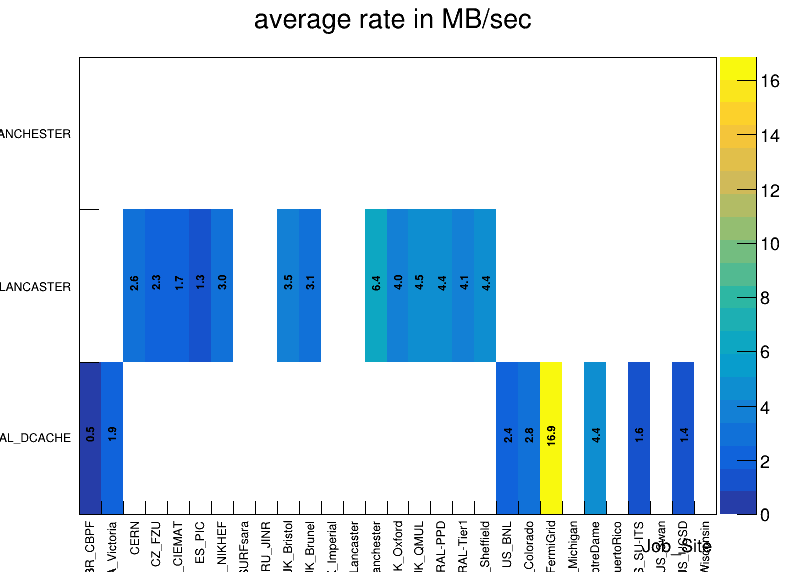

In [5]:
ROOT.gStyle.SetOptStat(0)

c ={}

ROOT.gStyle.SetPaintTextFormat("5.1f")
hists["Rate"].GetXaxis().LabelsOption("v");
hists["Rate"].GetYaxis().LabelsOption("v");
for i in range(0,hists["Rate"].GetNbinsX()+1):
    for j in range(0,hists["Rate"].GetNbinsY()+1):
        if hists["RateN"].GetBinContent(i,j) < 5:
            hists["Rate"].SetBinContent(i,j,0.0)  
         
hists["AverageRate"] = hists["Rate"].Clone("AverageRate")
hists["AverageRate"].Divide(hists["RateN"])

for state in ["Requested","Opened","Closed","Rate","AverageRate"]:
    
    c[state] =ROOT.TCanvas(state,state,800,600)
    if "Rate" in state:
        hists[state].SetTitle("average rate in MB/sec")
        hists[state].Draw("colz")
        hists[state].Draw("TEXT90 SAME")
        c[state].Draw()
        c[state].Print(state+".jpg")
        continue
    if state == "Requested": 
        opt = "box"
        
    else:
        opt = "box same"
    
    hists[state].Draw(opt)
    hists[state].Draw("TEXT90 SAME")
    
    c[state].Draw()

    

Info in <TCanvas::Print>: jpg file c1.jpg has been created


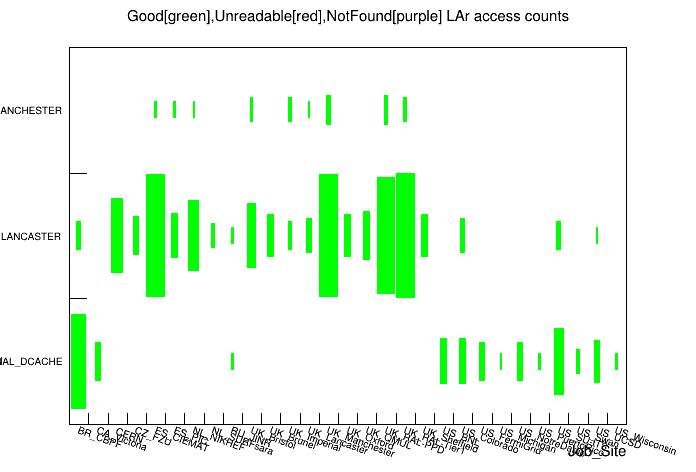

In [6]:
    
c1 = ROOT.TCanvas()
c1.cd()
hists["Combo"]=hists["Closed"].Clone("Combo")
hists["Combo"].SetTitle("Good[green],Unreadable[red],NotFound[purple] LAr access counts")
hists["Combo"].Draw("box")
hists["Opened"].Draw("box same")
hists["Requested"].Draw("box same")
c1.Draw()
c1.Print("c1.jpg","jpg")